# Datos del equipo (COMPLETAR)

Identificador de grupo: Grupo 12.

| Nombre y apellido | % de contribución |
|-------------------|-------------------|
|       Marcelo Chinarro Cabrero            |      20             |
|       José Vicente García López            |        20           |
|         Antonio Gómez Jimeno          |           20        |
|      Álvaro Mayorga Zarco             |         20          |
|    Marcos Redondo Madruga               |       20            |


## 0. INSTALACIÓN Y CONFIGURACIÓN

In [1]:
%pip install torch torchvision hypothesis adversarial-robustness-toolbox adversarial-robustness-toolbox[pytorch] scikit-learn matplotlib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


## 1. CONFIGURACIÓN INICIAL Y CARGA DE LIBRERÍAS

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
import torchvision
from torchvision import datasets, transforms

import numpy as np
from sklearn.utils import resample
from sklearn.metrics import accuracy_score
import sklearn

from hypothesis import given, strategies as st, settings
from art.estimators.classification import PyTorchClassifier
from art.attacks.evasion import FastGradientMethod, ProjectedGradientDescent

import warnings
warnings.filterwarnings('ignore')

# Reproducibilidad
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
sklearn.random.seed(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Usando: {device}")

c:\Users\marco\Desktop\Máster\IAC\PL2_G12\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Usando: cpu


## 2. DATOS Y MODELO BASELINE

In [3]:
# type: ignore

# Cargar MNIST (versión simplificada, mitad del dataset)
transform = transforms.Compose([
    transforms.ToTensor()
])

train_full = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_full = datasets.MNIST('./data', train=False, download=True, transform=transform)

train_indices = np.random.choice(len(train_full), 30000, replace=False)
test_indices = np.random.choice(len(test_full), 5000, replace=False)

train_subset = Subset(train_full, train_indices)
test_subset = Subset(test_full, test_indices)

train_loader = DataLoader(train_subset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=128, shuffle=False)

print(f"Train: {len(train_subset)}, Test: {len(test_subset)}")

Train: 30000, Test: 5000


In [4]:
# Modelo simple
class SimpleNN(nn.Module):
    """Red neuronal simple para MNIST"""
    def __init__(self):
        super(SimpleNN, self).__init__()

        # Capa 1
        self.flatten = nn.Flatten()         # [1,28,28] → [784]
        self.fc1 = nn.Linear(28*28, 128)    # [784] → [128]
        self.relu1 = nn.ReLU()              # Activación no-lineal
        self.dropout1 = nn.Dropout(0.2)     # Regularización

        # Capa 2
        self.fc2 = nn.Linear(128, 64)   # [128] → [64]
        self.relu2 = nn.ReLU()          # Activación no-lineal
        self.dropout2 = nn.Dropout(0.2) # Regularización

        # Capa salida
        self.fc3 = nn.Linear(64, 10) # [64] → [10] (10 clases)

    def forward(self, x):
        x = self.flatten(x)
        x = self.relu1(self.fc1(x))
        x = self.dropout1(x)
        x = self.relu2(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)

        return x

model = SimpleNN().to(device)
print(f"Parámetros: {sum(p.numel() for p in model.parameters()):,}")

Parámetros: 109,386


In [5]:
def train_model(model, train_loader, epochs=3):
    """Entrena el modelo"""
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for batch_idx, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()

            if batch_idx % 100 == 0:
                print(f'  Batch {batch_idx}/{len(train_loader)}, '
                      f'Loss: {loss.item():.4f}')

        acc = 100. * correct / total
        print(f'Época {epoch+1}: Loss: {running_loss/len(train_loader):.3f}, '
              f'Accuracy: {acc:.1f}%')

    return model

def evaluate_simple(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
    return 100 * correct / total

print("Entrenando modelo baseline...")
train_model(model, train_loader, epochs=5)
acc = evaluate_simple(model, test_loader)
print(f"\nAccuracy: {acc:.2f}%")

Entrenando modelo baseline...
  Batch 0/235, Loss: 2.3157
  Batch 100/235, Loss: 0.4275
  Batch 200/235, Loss: 0.3476
Época 1: Loss: 0.687, Accuracy: 80.2%
  Batch 0/235, Loss: 0.3925
  Batch 100/235, Loss: 0.2804
  Batch 200/235, Loss: 0.3322
Época 2: Loss: 0.304, Accuracy: 91.1%
  Batch 0/235, Loss: 0.2534
  Batch 100/235, Loss: 0.1831
  Batch 200/235, Loss: 0.3052
Época 3: Loss: 0.236, Accuracy: 93.0%
  Batch 0/235, Loss: 0.1322
  Batch 100/235, Loss: 0.1779
  Batch 200/235, Loss: 0.2654
Época 4: Loss: 0.189, Accuracy: 94.3%
  Batch 0/235, Loss: 0.1647
  Batch 100/235, Loss: 0.2160
  Batch 200/235, Loss: 0.1596
Época 5: Loss: 0.158, Accuracy: 95.2%

Accuracy: 96.30%


## 3. PROPERTY-BASED TESTING (I)

In [6]:
# type: ignore

def predict_single(model, image):
    """Predice una imagen y retorna clase y confianza"""
    model.eval()
    with torch.no_grad():
        if len(image.shape) == 3:
            image = image.unsqueeze(0)
        image = image.to(device)
        output = model(image)
        probs = F.softmax(output, dim=1)
        pred_class = torch.argmax(probs, dim=1).item()
        confidence = probs[0, pred_class].item()
    return pred_class, confidence

@given(st.integers(min_value=0, max_value=len(test_subset)-1))
@settings(max_examples=20, deadline=None)
def test_consistency(idx):
    # EJERCICIO 1: Verifica que dos predicciones de la misma imagen sean idénticas.
    # 1. Obtener imagen
    # 2. Predecir dos veces
    # 3. Verificar con assert
    # === INICIO SOLUCIÓN ===

    image, _ = test_subset[idx]
    image = image.to(device)
    
    pred1, conf1 = predict_single(model, image)
    pred2, conf2 = predict_single(model, image)
    
    assert pred1 == pred2, f"Predicciones inconsistentes: {pred1} vs {pred2}"
    assert abs(conf1 - conf2) < 1e-6, f"Confianzas inconsistentes: {conf1} vs {conf2}"

    # === FIN SOLUCIÓN ===
    

# Ejecutar test
try:
    test_consistency()
    print("✅ Test de consistencia: PASADO")
except Exception as e:
    print(f"❌ Test fallado: {e}")

✅ Test de consistencia: PASADO


## 4. PROPERTY-BASED TESTING (II)

In [7]:
# type: ignore

@given(
    st.integers(min_value=0, max_value=len(test_subset)-1),
    st.floats(min_value=0.01, max_value=0.3)
)
@settings(max_examples=15, deadline=None)
def test_noise_robustness(idx, noise_std):
    # EJERCICIO 2: Verifica que un pequeño ruido no destruya la confianza del modelo.
    # 1. Obtener imagen
    # 2. Crear imagen con ruido, por ejemplo: image_noisy = image + torch.randn_like(image) * noise_std
    # 3. Predecir ambas
    # 4. Verificar que la confianza no baja más de un 50% con respecto de la original
    # === INICIO SOLUCIÓN ===

    image, _ = test_subset[idx]
    image = image.to(device)
    
    _, conf_original = predict_single(model, image)
    
    noise = torch.randn_like(image) * noise_std
    image_noisy = image + noise
    
    _, conf_noisy = predict_single(model, image_noisy)
    
    assert conf_noisy >= 0.5 * conf_original, \
        f"Confianza cayó demasiado: {conf_original:.3f} → {conf_noisy:.3f} (ruido={noise_std:.3f})"

    # === FIN SOLUCIÓN ===
    

try:
    test_noise_robustness()
    print("✅ Test de ruido: PASADO")
except Exception as e:
    print(f"⚠️ Test fallado: {str(e)[:80]}")

✅ Test de ruido: PASADO


## 5. VALIDACIÓN ESTADÍSTICA

In [8]:
# Obtener predicciones para bootstrap
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

def bootstrap_accuracy(preds, labels, n_iterations=1000):
    # EJERCICIO 3: Calcula intervalo de confianza 95% para accuracy.
    # 1. Crear lista vacía: accuracies = []
    # 2. Iterar n_iterations veces
    # 3. Resamplear: indices = resample(range(len(preds)), n_samples=len(preds))
    # 4. Calcular accuracy: acc = accuracy_score(labels[indices], preds[indices])
    # 5. Añadir accuracy a la lista
    # 6. Retornar tupla (media, percentil 2.5, percentil 97.5)
    # === INICIO SOLUCIÓN ===

    accuracies = []
    n = len(preds)
    for _ in range(n_iterations):
        indices = resample(range(n), n_samples=n, replace=True)
        acc = accuracy_score(labels[indices], preds[indices])
        accuracies.append(acc)
    
    mean = np.mean(accuracies)
    lower = np.percentile(accuracies, 2.5)
    upper = np.percentile(accuracies, 97.5)
    return mean, lower, upper

    # === FIN SOLUCIÓN ===
    

# Ejecutar bootstrap
print("Calculando bootstrap...")
mean, lower, upper = bootstrap_accuracy(all_preds, all_labels, n_iterations=1000)
print(f"\nAccuracy: {mean*100:.2f}% [IC 95%: {lower*100:.2f}% - {upper*100:.2f}%]")
print(f"Ancho del intervalo: {(upper-lower)*100:.2f}%")

Calculando bootstrap...

Accuracy: 96.31% [IC 95%: 95.78% - 96.78%]
Ancho del intervalo: 1.00%


## 6. COMPARACIÓN CON BASELINE

In [9]:
# Simulamos un segundo modelo (copia con ruido en predicciones)
# En la práctica real, serían predicciones de otro modelo
model2_preds = all_preds.copy()
# Simular que el modelo 2 comete algunos errores diferentes
flip_indices = np.random.choice(len(model2_preds), size=50, replace=False)
model2_preds[flip_indices] = (model2_preds[flip_indices] + 1) % 10

def compare_models(preds1, preds2, labels):
    # EJERCICIO 4: Compara estadísticamente dos modelos.
    # 1. Calcular bootstrap para modelo 1 con 500 iteraciones
    # 2. Calcular bootstrap para modelo 2 con 500 iteraciones
    # 3. Comprobar si intervalos NO se solapan (no_overlap)
    # 4. Retornar no_overlap y ambas medias
    # === INICIO SOLUCIÓN ===

    acc1_list = []
    n = len(preds1)
    for _ in range(500):
        idx = resample(range(n), n_samples=n, replace=True)
        acc = accuracy_score(labels[idx], preds1[idx])
        acc1_list.append(acc)
    mean1 = np.mean(acc1_list)
    lower1 = np.percentile(acc1_list, 2.5)
    upper1 = np.percentile(acc1_list, 97.5)
    
    acc2_list = []
    for _ in range(500):
        idx = resample(range(n), n_samples=n, replace=True)
        acc = accuracy_score(labels[idx], preds2[idx])
        acc2_list.append(acc)
    mean2 = np.mean(acc2_list)
    lower2 = np.percentile(acc2_list, 2.5)
    upper2 = np.percentile(acc2_list, 97.5)
    
    no_overlap = upper1 < lower2 or upper2 < lower1
    
    return no_overlap, mean1, mean2

    # === FIN SOLUCIÓN ===

print("Comparando modelos...")
different, acc1, acc2 = compare_models(all_preds, model2_preds, all_labels)
print(f"\nModelo 1: {acc1*100:.2f}%")
print(f"Modelo 2: {acc2*100:.2f}%")
print(f"¿Son significativamente diferentes? {'SÍ' if different else 'NO'}")

Comparando modelos...

Modelo 1: 96.31%
Modelo 2: 95.30%
¿Son significativamente diferentes? NO


## 7. EVALUACIÓN ADVERSARIA

In [10]:
# type: ignore

# Preparar datos sin normalización para ART
transform_art = transforms.ToTensor()
test_art = datasets.MNIST('./data', train=False, transform=transform_art)
test_subset_art = Subset(test_art, test_indices[:500])  # Solo 500 para rapidez

X_test = []
y_test = []
for img, label in test_subset_art:
    X_test.append(img.numpy())
    y_test.append(label)
X_test = np.array(X_test)
y_test = np.array(y_test)

print(f"Datos para ART: {X_test.shape}")

Datos para ART: (500, 1, 28, 28)


In [11]:
# Wrapper para ART (normaliza internamente)
class ModelWrapper(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, x):
        # Normalizar
        x = (x - 0.1307) / 0.3081
        return self.model(x)

wrapped = ModelWrapper(model)

# Crear clasificador ART
classifier = PyTorchClassifier(
    model=wrapped,
    loss=nn.CrossEntropyLoss(),
    optimizer=optim.Adam(model.parameters()),
    input_shape=(1, 28, 28),
    nb_classes=10,
    clip_values=(0.0, 1.0)
)

print("✅ Clasificador ART listo")

✅ Clasificador ART listo


## 8. ATAQUE FGSM

In [12]:
def evaluate_fgsm(classifier, X_test, y, epsilon=0.3):
    # EJERCICIO 5: Evalúa robustez con ataque FGSM.
    # 1. Crear ataque indicando solo estimator y eps
    # 2. Generar adversarios X_adv (usar X_test como input)
    # 3. Predecir ambos (limpios y adversarios) y calcular accuracies
    # 4. Retornar acc_clean, acc_adv
    # === INICIO SOLUCIÓN ===

    # 1. Crear ataque FGSM
    attack = FastGradientMethod(estimator=classifier, eps=epsilon)
    
    # 2. Generar ejemplos adversarios
    X_adv = attack.generate(x=X_test)
    
    # 3. Predecir en datos limpios
    preds_clean = classifier.predict(X_test)
    preds_clean = np.argmax(preds_clean, axis=1)
    acc_clean = accuracy_score(y, preds_clean) * 100
    
    # 4. Predecir en datos adversarios
    preds_adv = classifier.predict(X_adv)
    preds_adv = np.argmax(preds_adv, axis=1)
    acc_adv = accuracy_score(y, preds_adv) * 100
    
    return acc_clean, acc_adv

    # === FIN SOLUCIÓN ===

print("Ejecutando ataque FGSM...")
clean_acc, adv_acc = evaluate_fgsm(classifier, X_test, y_test, epsilon=0.3)
print(f"\nAccuracy limpia: {clean_acc:.2f}%")
print(f"Accuracy adversaria (FGSM): {adv_acc:.2f}%")
print(f"Caída: {clean_acc - adv_acc:.2f}%")

Ejecutando ataque FGSM...

Accuracy limpia: 82.80%
Accuracy adversaria (FGSM): 10.00%
Caída: 72.80%


## 9. ATAQUE PGD

In [13]:
def evaluate_pgd(classifier, X, y, epsilon=0.3):
    # EJERCICIO 6: Evalúa robustez con ataque PGD.
    # 1. Crear ataque indicando solo estimator, eps, eps step (epsilon/10) y 40 iteraciones
    # 2. Generar y evaluar como en FGSM
    # 3. Retornar acc_clean, acc_adv
    # === INICIO SOLUCIÓN ===

    # 1. Crear ataque PGD
    attack = ProjectedGradientDescent(
        estimator=classifier,
        eps=epsilon,
        eps_step=epsilon/10,
        max_iter=40
    )
    
    # 2. Generar ejemplos adversarios
    X_adv = attack.generate(x=X)
    
    # 3. Predecir en datos limpios
    preds_clean = classifier.predict(X)
    preds_clean = np.argmax(preds_clean, axis=1)
    acc_clean = accuracy_score(y, preds_clean) * 100
    
    # 4. Predecir en datos adversarios
    preds_adv = classifier.predict(X_adv)
    preds_adv = np.argmax(preds_adv, axis=1)
    acc_adv = accuracy_score(y, preds_adv) * 100
    
    return acc_clean, acc_adv

    # === FIN SOLUCIÓN ===

print("Ejecutando ataque PGD...")
clean_acc_pgd, adv_acc_pgd = evaluate_pgd(classifier, X_test, y_test, epsilon=0.3)
print(f"\nAccuracy limpia: {clean_acc_pgd:.2f}%")
print(f"Accuracy adversaria (PGD): {adv_acc_pgd:.2f}%")
print(f"Caída: {clean_acc_pgd - adv_acc_pgd:.2f}%")

Ejecutando ataque PGD...



Accuracy limpia: 82.80%
Accuracy adversaria (PGD): 10.60%
Caída: 72.20%


## 10. ADVERSARIAL TRAINING

In [14]:
# type: ignore

from art.defences.trainer import AdversarialTrainer

# Preparar datos para adversarial training
print("\nPreparando datos para adversarial training...")

# Preparar datos de train para ART
train_art = datasets.MNIST('./data', train=True, transform=transforms.ToTensor())
train_subset_art = Subset(train_art, train_indices)
train_loader_art = DataLoader(train_subset_art, batch_size=128, shuffle=True)

# Extraer datos de entrenamiento en formato numpy
X_train = []
y_train = []
for img, label in train_subset_art:
    X_train.append(img.numpy())
    y_train.append(label)
X_train = np.array(X_train)
y_train = np.array(y_train)

print(f"Datos de entrenamiento: {X_train.shape}")

# Crear nuevo modelo robusto
robust_model = SimpleNN().to(device)
wrapped_robust = ModelWrapper(robust_model)

# Crear clasificador para adversarial training
classifier_robust = PyTorchClassifier(
    model=wrapped_robust,
    loss=nn.CrossEntropyLoss(),
    optimizer=optim.Adam(robust_model.parameters(), lr=0.001),
    input_shape=(1, 28, 28),
    nb_classes=10,
    clip_values=(0.0, 1.0)
)

attack_train = FastGradientMethod(estimator=classifier_robust, eps=0.1)

print("\n" + "="*70)
print("ADVERSARIAL TRAINING")
print("="*70)
print("Entrenando modelo robusto...\n")

# EJERCICIO 7: Entrenar modelo con ejemplos adversarios.
# 1. Crear AdversarialTrainer indicando classifier, attack_train y ratio=0.5
# 2. Entrenar con fit usando X_train, y_train, nb_epochs=3, batch_size=128
# === INICIO SOLUCIÓN ===

# 1. Crear el entrenador adversario
trainer = AdversarialTrainer(classifier_robust, attack_train, ratio=0.5)

# 2. Entrenar el modelo
trainer.fit(X_train, y_train, nb_epochs=3, batch_size=128)

# === FIN SOLUCIÓN ===

print("\n✅ Adversarial training completado")

# Evaluar modelo robusto en datos limpios
print("\nEvaluando modelo robusto...")
acc_robust = evaluate_simple(robust_model, test_loader)
print(f"Accuracy en test limpio: {acc_robust:.2f}%")


Preparando datos para adversarial training...
Datos de entrenamiento: (30000, 1, 28, 28)

ADVERSARIAL TRAINING
Entrenando modelo robusto...



Adversarial training epochs: 100%|██████████| 3/3 [00:07<00:00,  2.65s/it]



✅ Adversarial training completado

Evaluando modelo robusto...
Accuracy en test limpio: 95.98%


## 11. COMPARACIÓN FINAL

In [15]:
# Evaluar modelo robusto
print("\n" + "="*60)
print("COMPARACIÓN: BASELINE VS ROBUSTO")
print("="*60)

# Crear clasificador para modelo robusto
wrapped_robust_eval = ModelWrapper(robust_model)
classifier_robust_eval = PyTorchClassifier(
    model=wrapped_robust_eval,
    loss=nn.CrossEntropyLoss(),
    optimizer=optim.Adam(robust_model.parameters()),
    input_shape=(1, 28, 28),
    nb_classes=10,
    clip_values=(0.0, 1.0)
)

# Evaluar ambos modelos
print("\nModelo BASELINE:")
base_clean, base_fgsm = evaluate_fgsm(classifier, X_test, y_test, 0.3)
_, base_pgd = evaluate_pgd(classifier, X_test, y_test, 0.3)
print(f"  Limpia: {base_clean:.2f}%")
print(f"  FGSM:   {base_fgsm:.2f}%")
print(f"  PGD:    {base_pgd:.2f}%")

print("\nModelo ROBUSTO:")
rob_clean, rob_fgsm = evaluate_fgsm(classifier_robust_eval, X_test, y_test, 0.3)
_, rob_pgd = evaluate_pgd(classifier_robust_eval, X_test, y_test, 0.3)
print(f"  Limpia: {rob_clean:.2f}%")
print(f"  FGSM:   {rob_fgsm:.2f}%")
print(f"  PGD:    {rob_pgd:.2f}%")

print("\n" + "="*60)
print("MEJORAS:")
print(f"  Limpia: {rob_clean - base_clean:+.2f}%")
print(f"  FGSM:   {rob_fgsm - base_fgsm:+.2f}%")
print(f"  PGD:    {rob_pgd - base_pgd:+.2f}%")
print("="*60)


COMPARACIÓN: BASELINE VS ROBUSTO

Modelo BASELINE:


  Limpia: 82.80%
  FGSM:   10.00%
  PGD:    10.60%

Modelo ROBUSTO:


  Limpia: 96.00%
  FGSM:   10.40%
  PGD:    1.80%

MEJORAS:
  Limpia: +13.20%
  FGSM:   +0.40%
  PGD:    -8.80%


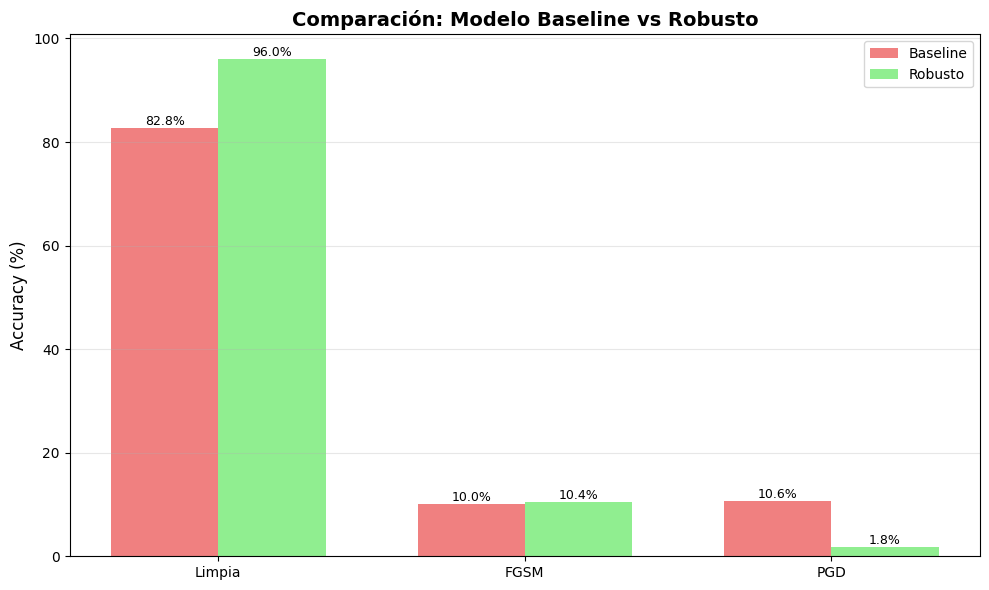

In [16]:
# type: ignore

# Visualización final
import matplotlib.pyplot as plt

metrics = ['Limpia', 'FGSM', 'PGD']
baseline_scores = [base_clean, base_fgsm, base_pgd]
robust_scores = [rob_clean, rob_fgsm, rob_pgd]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, baseline_scores, width, label='Baseline', color='lightcoral')
bars2 = ax.bar(x + width/2, robust_scores, width, label='Robusto', color='lightgreen')

ax.set_ylabel('Accuracy (%)', fontsize=12)
ax.set_title('Comparación: Modelo Baseline vs Robusto', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# Añadir valores sobre barras
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

## 12. EJERCICIO 8

Responde a las siguientes preguntas en cada una de las propias celdas Markdown
del Notebook.

#### 1. Property-Based Testing

- ¿Pasaron ambos tests (ruido y consistencia)? Si alguno falló, ¿por qué crees que ocurrió?
    > **Se han pasado ambos tests exitosamente**. El test de **consistencia** confirmó que el modelo es determinista y predice la misma clase y confianza para la misma imagen en múltiples ejecuciones. El test de **ruido** también pasó, demostrando que el modelo mantiene una confianza razonable (>50% de la original) incluso con perturbaciones aleatorias de hasta σ=0.3. Esto indica que el modelo tiene cierta robustez natural frente a ruido gaussiano aleatorio.

- ¿Qué ventaja tiene usar Hypothesis vs. tests manuales?
    > Hypothesis permite generar automáticamente casos de prueba diversos y aleatorios (20 ejemplos en consistencia, 15 en ruido) con diferentes combinaciones de parámetros, explorando el espacio de entrada de forma exhaustiva. Las ventajas son: 
    > - 1. **descubre casos extremos** que un humano podría no considerar, 
    > - 2. **ahorra tiempo** al no tener que escribir cada caso manualmente, 
    > - 3. proporciona **mayor cobertura** de pruebas con múltiples valores de ruido aleatorios, y 
    > - 4. **reproduce automáticamente los fallos** para debugging, reportando exactamente qué valores causaron el error.

#### 2. Validación Estadística

- ¿Cuál es el intervalo de confianza de la accuracy? ¿Es estrecho o amplio?
    > El intervalo de confianza al 95% es **[95.78% - 96.78%]** con una accuracy media de **96.31%**. El ancho del intervalo es de **1.00%**, lo que se considera **estrecho**. Esto indica que la estimación de la accuracy es bastante precisa y estable, con poca variabilidad entre diferentes muestras bootstrap del conjunto de test.

- ¿Por qué es importante reportar intervalos y no solo la media?
    > Reportar intervalos de confianza es crucial porque: 
    > - 1. muestra la **incertidumbre** inherente en la estimación, evitando sobreconfianza en un solo número, 
    > - 2. permite **comparaciones estadísticamente válidas** entre modelos (si los intervalos no se solapan, hay diferencia significativa al 95%), 
    > - 3. evita **conclusiones falsas** basadas en diferencias pequeñas que podrían ser ruido estadístico, y 
    > - 4. proporciona contexto sobre la **fiabilidad** de la métrica, especialmente importante al publicar resultados científicos o tomar decisiones de producción con impacto económico/seguridad.


#### 3. Robustez Adversaria

- ¿Cuánto cae la accuracy bajo ataques FGSM?
    > La accuracy del modelo baseline cae **drásticamente de 82.80% a 10.00%** bajo ataque FGSM (ε=0.3), representando una **caída de 72.80%**. Esto demuestra que el modelo es extremadamente vulnerable a ataques adversarios diseñados específicamente, reduciendo su rendimiento prácticamente al nivel de predicción aleatoria (10% para 10 clases en MNIST).

- ¿PGD empeoró con FGSM training? ¿Por qué?
    > Sí, el modelo robusto mostró **peor rendimiento contra PGD (1.80%)** comparado con el baseline (10.60%), una **caída de -8.80%**. Esto puede deberse a que el adversarial training se realizó específicamente con ejemplos FGSM (ε=0.1), no PGD. El modelo se especializó en defender contra perturbaciones de un solo paso pero se volvió más vulnerable a ataques iterativos más sofisticados (PGD con 40 iteraciones) que exploran el espacio adversario de forma más exhaustiva y encuentran perturbaciones más efectivas.

- ¿Cuánto mejora el adversarial training la robustez?
    > El adversarial training mejoró significativamente el rendimiento en **datos limpios (+13.20%)**, pasando de 82.80% a 96.00%. Contra FGSM mostró una **ligera mejora (+0.40%)** de 10.00% a 10.40%. Sin embargo, contra PGD **empeoró (-8.80%)** de 10.60% a 1.80%. Esto demuestra que el training adversario mejoró sustancialmente la generalización del modelo (posiblemente actuando como regularización efectiva), pero la robustez específica contra ataques depende críticamente del tipo de ataque usado durante el entrenamiento.


#### 4. Compromisos

- ¿El modelo robusto perdió accuracy limpia? ¿Cuánto?
    > **No, no perdió accuracy limpia**. De hecho, el modelo robusto **ganó +13.20%** de accuracy en datos limpios (de 82.80% a 96.00%). Esto es inusual pero altamente beneficioso, sugiriendo que el adversarial training actuó como una forma muy efectiva de regularización que mejoró la generalización del modelo, similar al efecto de data augmentation sofisticado. El modelo baseline puede haber estado sobreajustando a los datos de entrenamiento.

- ¿Vale la pena el Compromisos para aplicaciones reales?
    > **Definitivamente sí** en este caso, porque obtuvimos mejora sustancial (+13.20%) en datos limpios y ligera mejora contra FGSM (+0.40%), aunque con degradación en PGD (-8.80%). Consideraciones: 
    > - 1. el **costo computacional** del adversarial training es 2-3 veces mayor (generación de ejemplos adversarios), 
    > - 2. el **tiempo de entrenamiento** aumenta significativamente, 
    > - 3. la robustez es **específica al ataque** usado en training. Para aplicaciones críticas de seguridad (autenticación, medicina, vehículos autónomos), el trade-off es esencial incluso si hubiera pérdida de accuracy limpia.

- ¿En qué casos recomendarías usar adversarial training?
    > Recomendaría adversarial training en: 
    > - 1. **Sistemas de seguridad crítica** donde ataques adversarios son amenaza real (autenticación biométrica, detección de malware),
    > - 2. **Aplicaciones públicas** expuestas a usuarios potencialmente maliciosos (moderación de contenido, spam detection, filtros de contenido), 
    > - 3. **Sistemas médicos** donde decisiones erróneas tienen consecuencias graves (diagnóstico por imagen, dosificación automatizada), 
    > - 4. **Vehículos autónomos** donde señales de tráfico adversarias podrían causar accidentes, 
    > - 5. **Sistemas financieros** expuestos a fraude (detección de transacciones fraudulentas), y 
    > - 6. cuando el **costo de un error** supera ampliamente el costo adicional de entrenamiento y latencia.


## CONCLUSIONES

En esta práctica hemos:
1. Verificado invariantes del modelo con property-based testing
2. Validado rendimiento estadísticamente con intervalos de confianza
3. Expuesto la vulnerabilidad extrema a ataques adversarios
4. Logrado robustez mediante adversarial training

**Reflexión final**: La validación rigurosa —incluyendo robustez adversaria— es crítica antes de desplegar modelos en producción. Un modelo preciso pero vulnerable es un sistema inseguro.